In [1]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor
from PIL import Image


In [2]:
image_path = r"C:\Users\user\Desktop\output\OriginalWhatsApp Image 2025-07-13 at 11.00.05_81507a42.jpg"
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [3]:
input_point = np.array([[800, 500]]) 
input_label = np.array([1]) 

In [9]:
sam_checkpoint = r"C:\Users\user\Downloads\sam_vit_h_4b8939.pth"
model_type = "vit_h"

In [10]:
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device="cpu")  
predictor = SamPredictor(sam)


In [11]:
predictor.set_image(image_rgb)
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

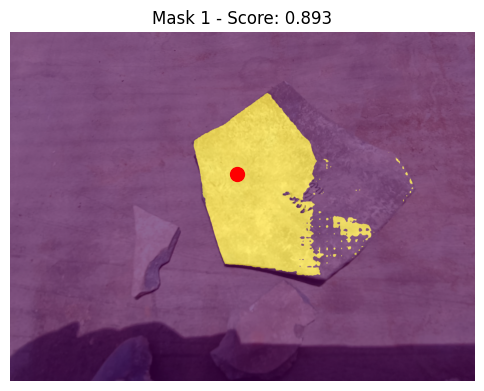

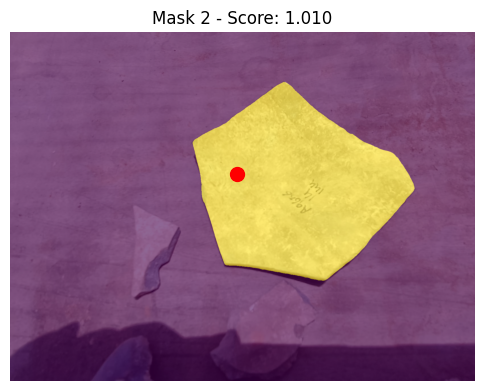

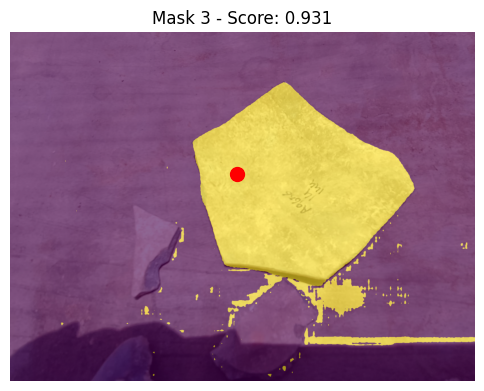

In [12]:
for i, mask in enumerate(masks):
    plt.figure(figsize=(6, 6))
    plt.imshow(image_rgb)
    plt.imshow(mask, alpha=0.6)
    plt.scatter(input_point[:, 0], input_point[:, 1], color='red', s=100)
    plt.title(f"Mask {i+1} - Score: {scores[i]:.3f}")
    plt.axis('off')
    plt.show()


## Segmentation by box:

In [13]:
    input_box = np.array([[650, 200, 1400, 850]])
masks, scores, logits = predictor.predict(
    box=input_box,
    multimask_output=True
)


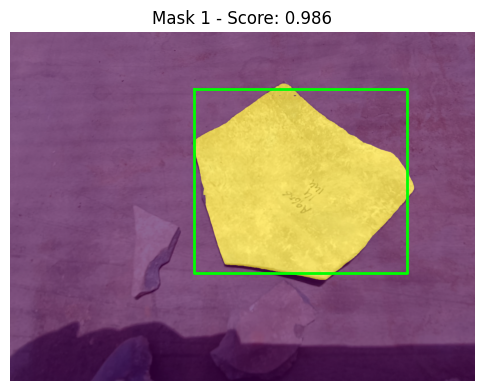

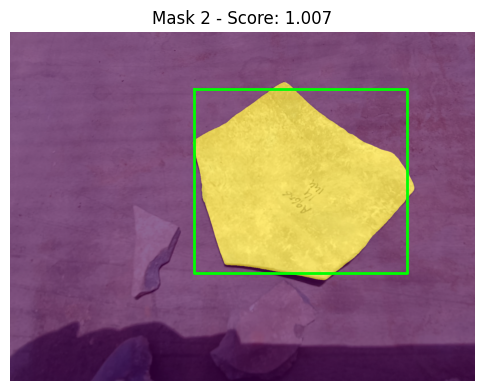

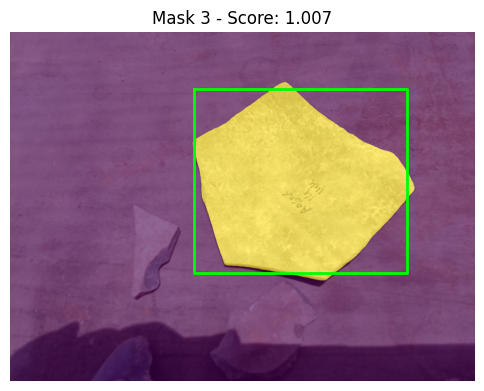

In [14]:
for i, mask in enumerate(masks):
    plt.figure(figsize=(6, 6))
    plt.imshow(image_rgb)
    plt.imshow(mask, alpha=0.6, cmap='viridis')  
    x0, y0, x1, y1 = input_box[0]
    plt.plot([x0, x1, x1, x0, x0], [y0, y0, y1, y1, y0], color='lime', linewidth=2)
    plt.title(f"Mask {i+1} - Score: {scores[i]:.3f}")
    plt.axis('off')
    plt.show()


## automatic_mask_generator

In [20]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import numpy as np
import cv2
import matplotlib.pyplot as plt


In [21]:
sam_checkpoint = "C:/Users/user/Downloads/sam_vit_h_4b8939.pth"
model_type = "vit_h"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device="cpu")  


Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [29]:
mask_generator = SamAutomaticMaskGenerator(sam)


In [30]:
image_path = r"C:\Users\user\Desktop\output\rotated_imgWhatsApp Image 2025-07-13 at 11.01.50_f390d12a.jpg"  
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


In [31]:
masks = mask_generator.generate(image)


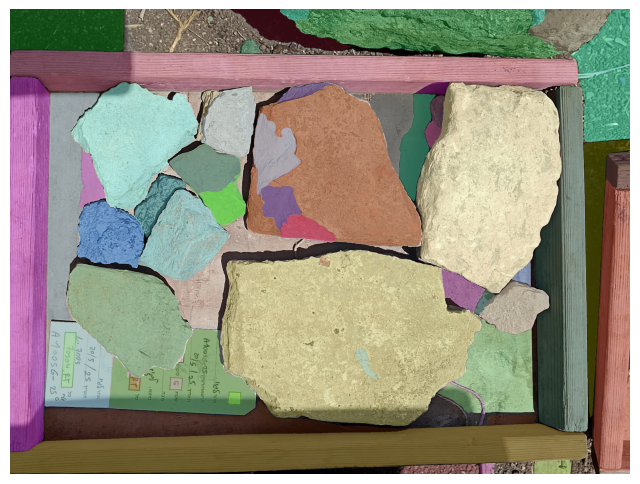

In [32]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random(3)
        for i in range(3):
            img[:, :, i] = color_mask[i]
        ax.imshow(np.dstack((img, m * 0.35)))

plt.figure(figsize=(8, 8))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()


# Segmentation by existing mask:

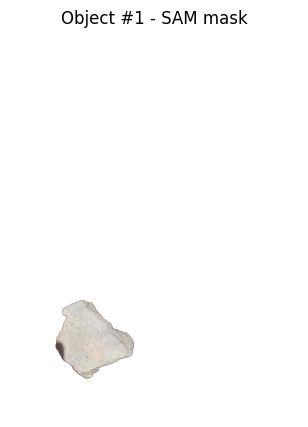

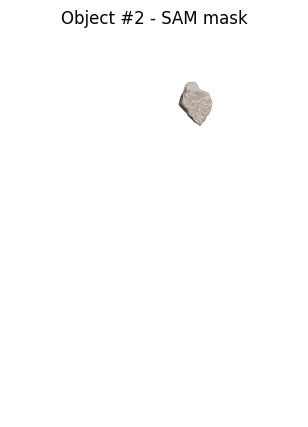

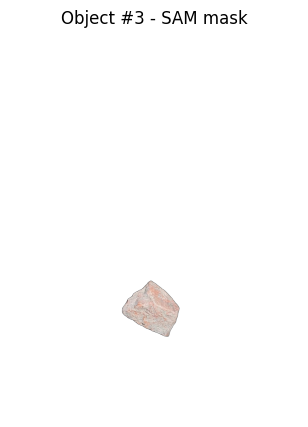

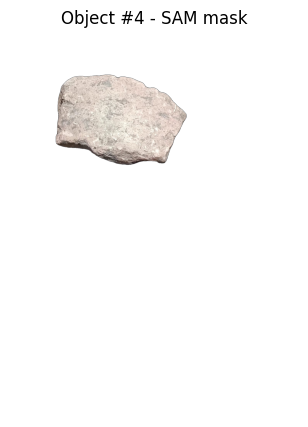

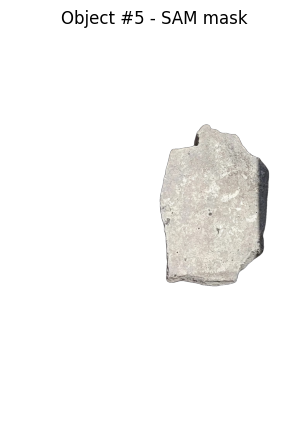

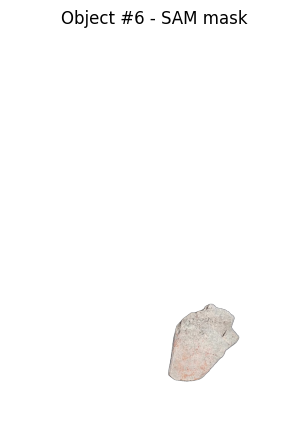

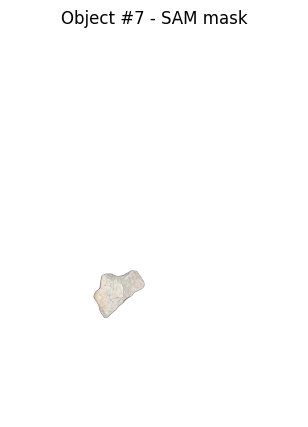

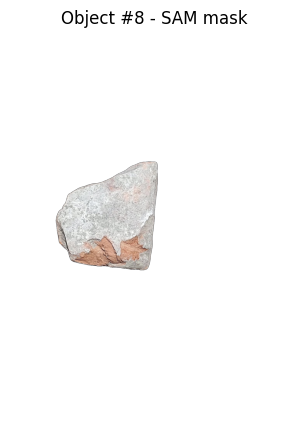

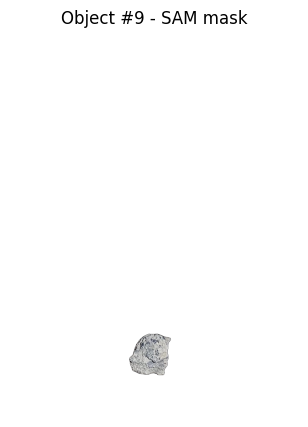

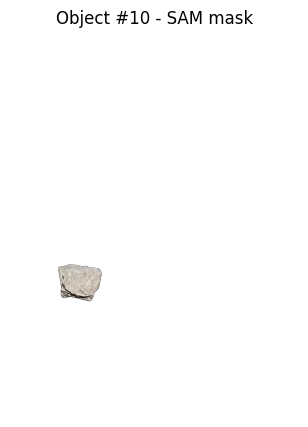

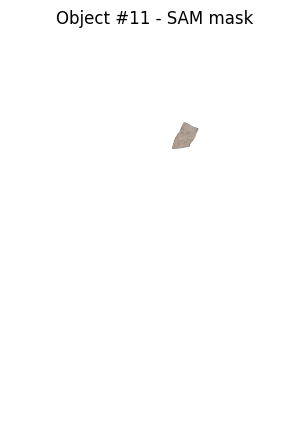

In [26]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor

# 1. Paths
image_path = r'C:\Users\user\Desktop\project_folder\images\test\OriginalWhatsApp Image 2025-07-13 at 11.01.50_f390d12a.jpg'
label_path = r'runs/detect/exp_reprocess/labels/OriginalWhatsApp Image 2025-07-13 at 11.01.50_f390d12a.txt'
sam_checkpoint = r"C:\Users\user\Downloads\sam_vit_h_4b8939.pth"
model_type = "vit_h"

# 2. Load image with OpenCV and PIL (for processing and display)
image_cv2 = cv2.imread(image_path)  # Load image in BGR format
image_rgb = cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)  # Convert to RGB
height, width = image_cv2.shape[:2]  # Get image dimensions
image_pil = Image.open(image_path).convert('RGB')  # Load image with PIL
image_np = np.array(image_pil)  # Convert to NumPy array (RGB format)

# 3. Load YOLO boxes from .txt file and convert to pixel coordinates
boxes = []
with open(label_path, 'r') as f:
    for line in f.readlines():
        parts = line.strip().split()
        _, cx, cy, w, h = map(float, parts)  # Ignore class ID, read normalized center and size
        x1 = int((cx - w/2) * width)   # Convert to pixel: top-left x
        y1 = int((cy - h/2) * height)  # Convert to pixel: top-left y
        x2 = int((cx + w/2) * width)   # Convert to pixel: bottom-right x
        y2 = int((cy + h/2) * height)  # Convert to pixel: bottom-right y
        boxes.append([x1, y1, x2, y2])  # Append box as [x1, y1, x2, y2]

boxes = np.array(boxes)  # Convert list of boxes to NumPy array

# 4. Load SAM model and set image
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)  # Load model from checkpoint
sam.to(device="cpu")  # Send model to CPU (use "cuda" for GPU)
predictor = SamPredictor(sam)
predictor.set_image(image_rgb)  # Set the input image for prediction

# 5. For each YOLO box: generate a mask, cut the object, and display
for i, box in enumerate(boxes):
    x1, y1, x2, y2 = box
    input_box = np.array([x1, y1, x2, y2])

    # Predict mask using SAM
    masks, scores, logits = predictor.predict(
        box=input_box,
        multimask_output=False,  # Only return best mask
    )
    mask = masks[0]  # Use the first (best) mask

    # Create alpha channel from the mask
    alpha = (mask * 255).astype(np.uint8)

    # Cut object from original image using mask
    cut_object = np.zeros((height, width, 4), dtype=np.uint8)  # Empty RGBA image
    for c in range(3):  # Fill R, G, B channels
        cut_object[..., c] = image_np[..., c] * mask
    cut_object[..., 3] = alpha  # Set alpha channel

    result = Image.fromarray(cut_object, mode="RGBA")  # Convert to PIL image

    # Show the result
    plt.figure(figsize=(5, 5))
    plt.imshow(result)
    plt.title(f"Object #{i+1} - SAM mask")
    plt.axis('off')
    plt.show()
